link up imgs in images/ with according id in data/legend.csv

In [1]:
import numpy as np
import data_processor
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from collections import defaultdict

%matplotlib inline

seed = 1234

# STEP 0 - GETTING THE DATA

In [2]:
get_data_from_file = False  # faster when this is False
DATA_IMG_SIZE = (100, 100)

# get data from file
if (get_data_from_file):
    DATA_FILE = "data_images_100_100.txt"
    data = np.genfromtxt(DATA_FILE)
    X = data[:, :-1]
    y = data[:, -1]

# generate data here
if not get_data_from_file:
    X, y = data_processor.convert_images(DATA_IMG_SIZE, True)
    X = np.array(X)
    y = np.char.lower(np.array(y))


--- Done reading legend.csv ---
--- Done turning images into vectors ---


In [3]:
print(X.shape)
print(y.shape)

(13690, 10000)
(13690,)


In [3]:
X_tr_unscaled, X_te_unscaled, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=seed, shuffle=True)

scaler = StandardScaler()
scaler.fit(X_tr_unscaled)
X_tr = scaler.transform(X_tr_unscaled)     # We can forget about the original values & work
X_te = scaler.transform(X_te_unscaled)     #  just with the transformed values from here

In [4]:
X_tr_subset = X_tr[:10000]
y_tr_subset = y_tr[:10000]

In [5]:
neural_network = MLPClassifier(hidden_layer_sizes=[128],
                               activation='logistic',
                               solver='adam',
                               batch_size=200,
                               max_iter=500,
                               learning_rate='adaptive',
                               learning_rate_init=0.01,
                               random_state=seed)
neural_network.fit(X_tr_subset, y_tr_subset)

MLPClassifier(activation='logistic', batch_size=200, hidden_layer_sizes=[128],
              learning_rate='adaptive', learning_rate_init=0.01, max_iter=500,
              random_state=1234)

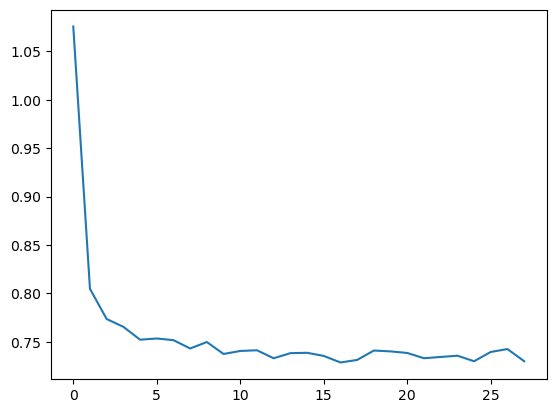

In [6]:
curve = neural_network.loss_curve_
plt.plot(range(len(curve)), curve)

In [7]:
yp = neural_network.predict(X_tr_subset)
countsp = defaultdict(int)
for i in yp:
    countsp[i] += 1
print(countsp)
print('training error rate: ' + str(sum([0 if y == yp else 1 for y, yp in zip(y_tr_subset, neural_network.predict(X_tr_subset))])/len(y_tr_subset)))
print('evaluation error rate: '+ str(sum([0 if y == yp else 1 for y, yp in zip(y_te, neural_network.predict(X_te))])/len(y_te)))

# the network has trouble predicting emotions like sadness, contempt, anger, disgust because there are few of them in the dataset compared to happiness and neutral.


defaultdict(<class 'int'>, {'happiness': 3501, 'neutral': 6410, 'surprise': 55, 'disgust': 21, 'anger': 12, 'sadness': 1})
training error rate: 0.2546
evaluation error rate: 0.29510591672753833


# Oversampling for Dataset Balance

In [13]:
counts = defaultdict(int)
for i in y:
    counts[i] += 1
print('before oversampling:')
print(counts)

# compute indices of classes
contempt_i = np.where(y == 'contempt')[0]
fear_i = np.where(y == 'fear')[0]
disgust_i = np.where(y == 'disgust')[0]
anger_i = np.where(y == 'anger')[0]
sadness_i = np.where(y == 'sadness')[0]
surprise_i = np.where(y == 'surprise')[0]

# calculate how many times to duplicate data
contempt_times = int(counts['neutral'] / counts['contempt']) - 1
fear_times = int(counts['neutral'] / counts['fear']) - 1
disgust_times = int(counts['neutral'] / counts['disgust']) - 1
anger_times = int(counts['neutral'] / counts['anger']) - 1
sadness_times = int(counts['neutral'] / counts['sadness']) - 1
surprise_times = int(counts['neutral'] / counts['surprise']) - 1

contempt_X = np.repeat(X[contempt_i], contempt_times, axis=0)
fear_X = np.repeat(X[fear_i], fear_times, axis=0)
disgust_X = np.repeat(X[disgust_i], disgust_times, axis=0)
anger_X = np.repeat(X[anger_i], anger_times, axis=0)
sadness_X = np.repeat(X[sadness_i], sadness_times, axis=0)
surprise_X = np.repeat(X[surprise_i], surprise_times, axis=0)

X_balanced = np.concatenate((X, contempt_X, fear_X, disgust_X, anger_X, sadness_X, surprise_X), axis=0)
y_balanced = np.concatenate((y,
                                np.repeat(['contempt'], contempt_times * counts['contempt']),
                                np.repeat(['fear'], fear_times * counts['fear']),
                                np.repeat(['disgust'], disgust_times * counts['disgust']),
                                np.repeat(['anger'], anger_times * counts['anger']),
                                np.repeat(['sadness'], sadness_times * counts['sadness']),
                                np.repeat(['surprise'], surprise_times * counts['surprise'])), axis=0)

counts_after = defaultdict(int)
for i in y_balanced:
    counts_after[i] += 1
print('\nafter:')
print(counts_after)







before oversampling:
defaultdict(<class 'int'>, {'anger': 252, 'surprise': 368, 'disgust': 208, 'fear': 21, 'neutral': 6868, 'happiness': 5696, 'sadness': 268, 'contempt': 9})

after:
defaultdict(<class 'int'>, {'anger': 6804, 'surprise': 6624, 'disgust': 6864, 'fear': 6867, 'neutral': 6868, 'happiness': 5696, 'sadness': 6700, 'contempt': 6867})


In [14]:
# shuffle oversampled data
np.random.seed(seed)
shuffled_indices = np.arange(y_balanced.shape[0])
np.random.shuffle(shuffled_indices)

X_tr_balanced_shuffled = X_balanced[shuffled_indices]
y_tr_balanced_shuffled = y_balanced[shuffled_indices]

In [15]:
X_tr_unscaled, X_te_unscaled, y_tr, y_te = train_test_split(X_tr_balanced_shuffled, y_tr_balanced_shuffled, test_size=0.2, random_state=seed, shuffle=True)

scaler = StandardScaler()
scaler.fit(X_tr_unscaled)
X_tr = scaler.transform(X_tr_unscaled)     # We can forget about the original values & work
X_te = scaler.transform(X_te_unscaled)     #  just with the transformed values from here

In [16]:
X_tr_subset = X_tr[:10000]
y_tr_subset = y_tr[:10000]

In [17]:
neural_network = MLPClassifier(hidden_layer_sizes=[128],
                               activation='logistic',
                               solver='adam',
                               batch_size=200,
                               max_iter=500,
                               learning_rate='adaptive',
                               learning_rate_init=0.01,
                               random_state=seed)
neural_network.fit(X_tr_subset, y_tr_subset)


MLPClassifier(activation='logistic', batch_size=200, hidden_layer_sizes=[128],
              learning_rate='adaptive', learning_rate_init=0.01, max_iter=500,
              random_state=1234)

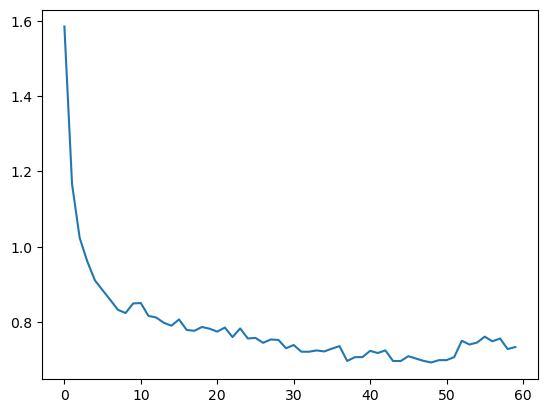

In [19]:
curve = neural_network.loss_curve_
plt.plot(range(len(curve)), curve)

training error rate: 0.2348
evaluation error rate: 0.26684180896978793
(2348,)


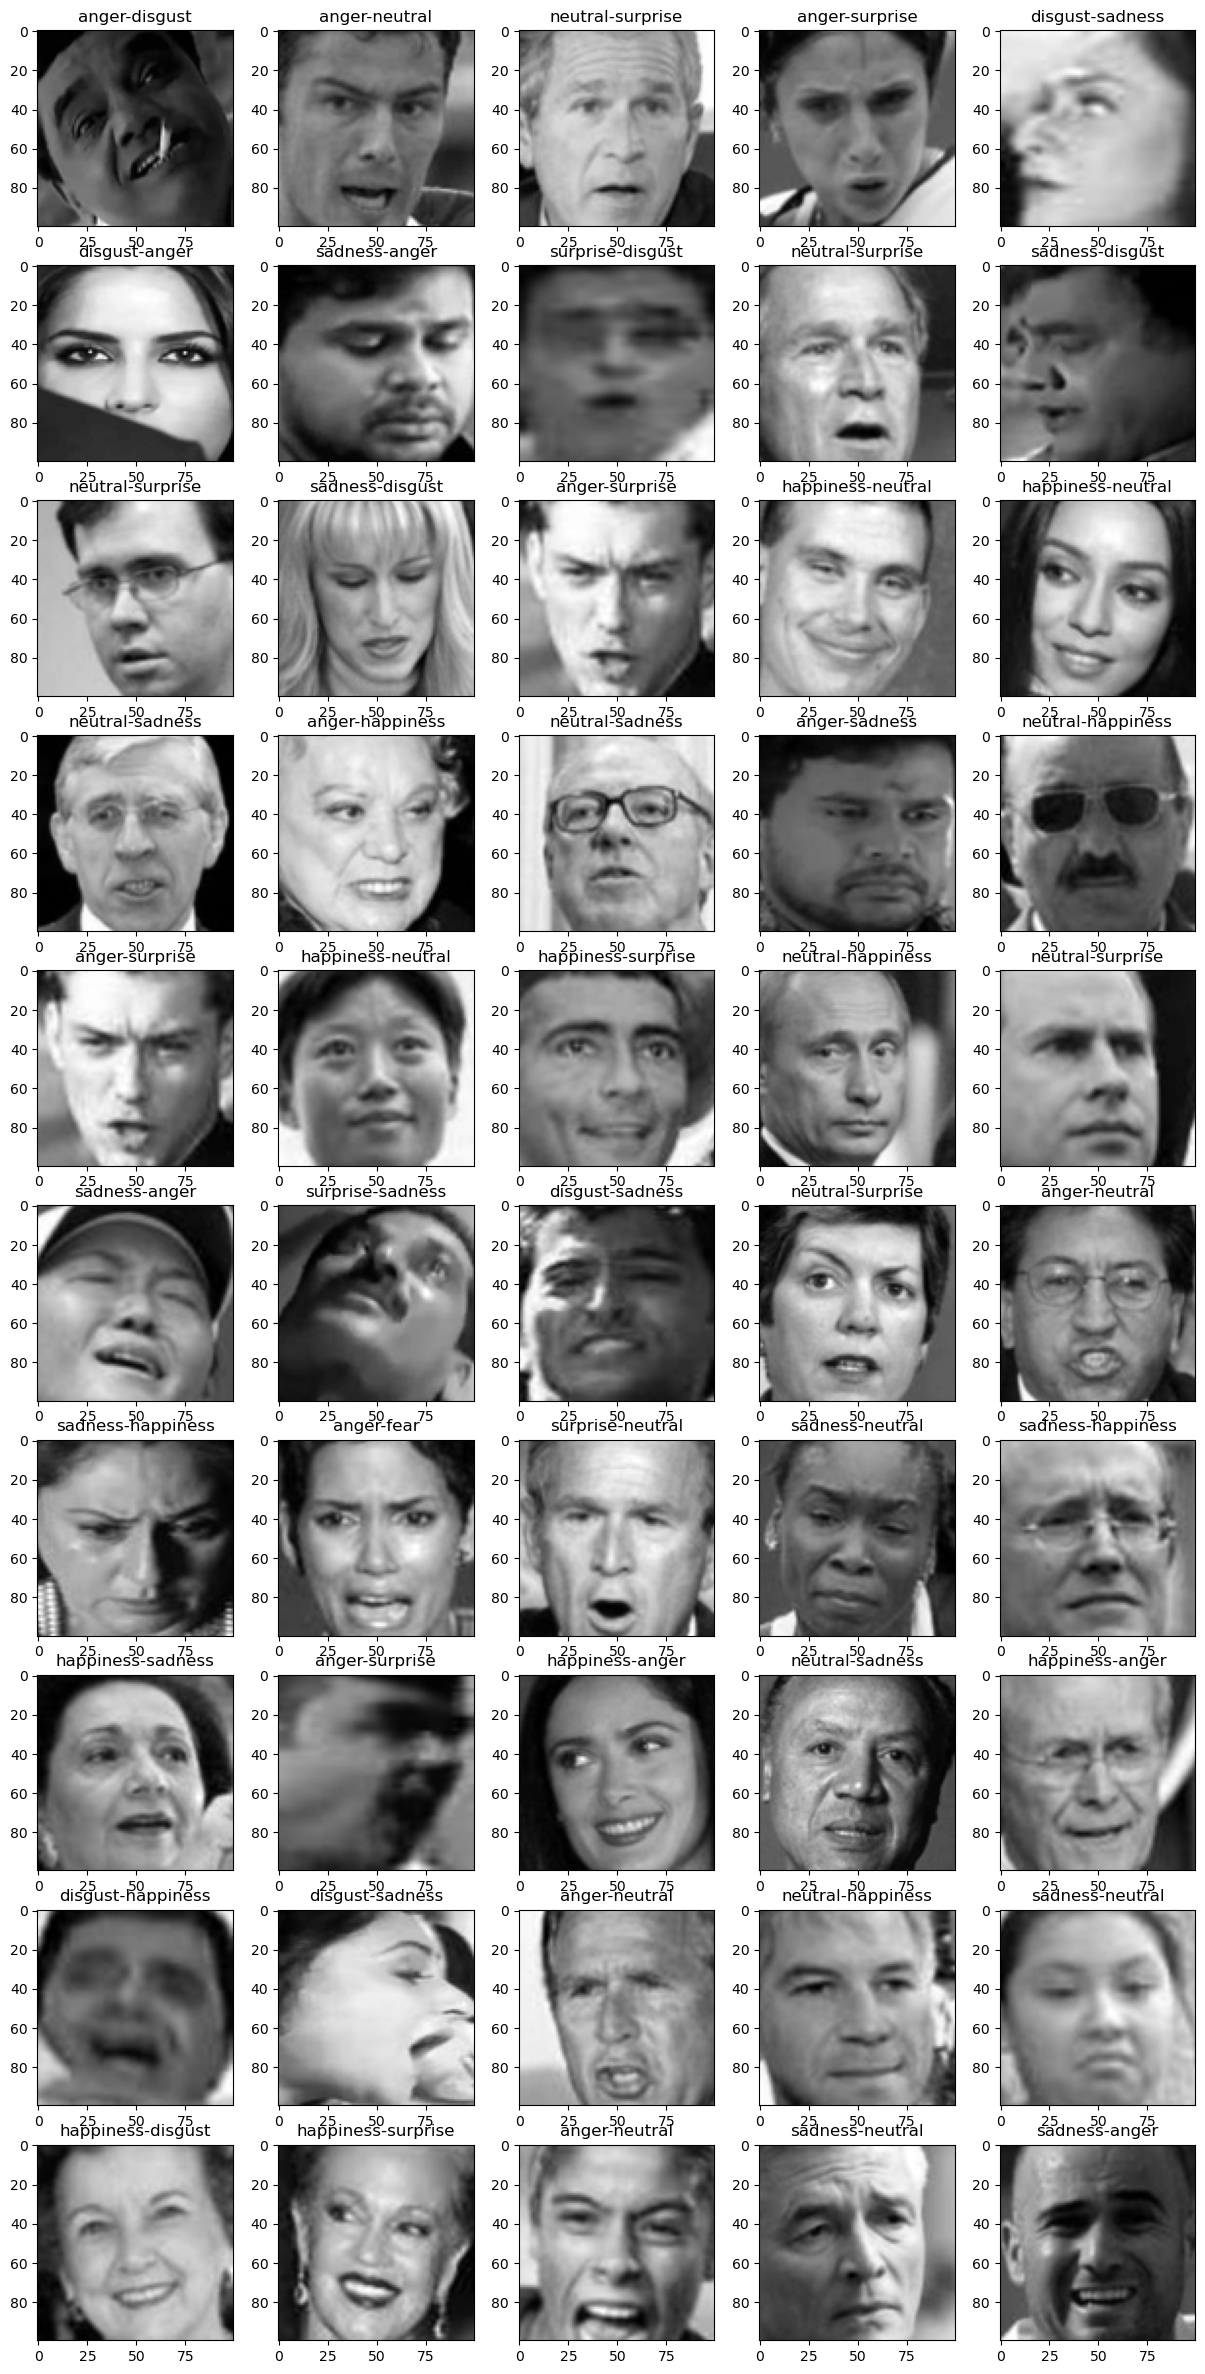

In [21]:
yp = neural_network.predict(X_tr_subset)
countsp = defaultdict(int)
for i in yp:
    countsp[i] += 1
print('training error rate: ' + str(sum([0 if y == yp else 1 for y, yp in zip(y_tr_subset, neural_network.predict(X_tr_subset))])/len(y_tr_subset)))
print('evaluation error rate: '+ str(sum([0 if y == yp else 1 for y, yp in zip(y_te, neural_network.predict(X_te))])/len(y_te)))
wrong_i = np.where((yp != y_tr_subset))[0]
print(wrong_i.shape)

r = 10
c = 5

fig, ax = plt.subplots(r,c)
fig.set_figheight(30)
fig.set_figwidth(15)
for i in range(r):
    for j in range(c):
        ax[i, j].imshow(X_tr_unscaled[wrong_i[i*r + j]].reshape(100,100), cmap='gray')
        ax[i, j].set_title(y_tr_subset[wrong_i[i*r + j]] + '-' + yp[wrong_i[i*r + j]])